Comment utiliser le pipeline de sk learn

In [120]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_transformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder, OneHotEncoder, Binarizer, PolynomialFeatures,MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import seaborn as sns

import pandas as pd 
import numpy as np 

dataframe = pd.read_csv("dataset.csv", sep=",", index_col=False)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [109]:
bins = [0, 18.5, 25, 30, 35, 40, float('inf')]
labels = ['Poids insuffisant', 'Poids normal', 'Surpoids', 'Obésité grade I', 'Obésité grade II', 'Obésité grade III']

# Remplacer le bmi_encoder par la catégorisation d'IMC
dataframe['bmi_category'] = pd.cut(dataframe['bmi'], bins=bins, labels=labels, right=False)

# Encodage numérique des catégories d'IMC
category_mapping = {
    'Poids insuffisant': 0,
    'Poids normal': 1,
    'Surpoids': 2,
    'Obésité grade I': 3,
    'Obésité grade II': 4,
    'Obésité grade III': 5
}
dataframe['bmi_encoded'] = dataframe['bmi_category'].map(category_mapping)

In [132]:
#no age encoder
sex_encoder = OrdinalEncoder(categories=[['female', 'male']])

bmi_encoder= Binarizer(threshold=30)
#no children encoder
smoker_encoder = OrdinalEncoder(categories=[['no', 'yes']])
region_encoder = OneHotEncoder()

#encodage useless 
numeric = ["age","bmi","children"]
categoriel = ['region','sex','smoker']
transformer = make_column_transformer(
    (MinMaxScaler(), numeric),
    (OneHotEncoder(), categoriel)
)
#transformer.fit_transform(X)
#dataframe[["sex"]]
#sex_encoder.fit_transform(dataframe[["sex"]])

transformer

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['age', 'bmi', 'children']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['region', 'sex', 'smoker'])])

In [111]:
y = dataframe['charges']
X = dataframe.drop('charges', axis=1)

# pour pouvoir comparer le score
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])


In [112]:
age_pipeline = make_pipeline( StandardScaler())
sex_pipeline = make_pipeline( sex_encoder)
bmi_pipeline = make_pipeline( bmi_encoder)
children_pipeline = make_pipeline( StandardScaler())
smoker_pipeline = make_pipeline( smoker_encoder)
region_pipeline = make_pipeline( region_encoder)

In [113]:
first_pipeline = make_column_transformer(
    (age_pipeline, ['age']),
    (smoker_pipeline, ['smoker']),
    (bmi_pipeline, ['bmi']))

polynomial_pipeline = make_pipeline(first_pipeline, PolynomialFeatures(degree=2))

preprocessor = make_column_transformer( 
    (polynomial_pipeline, ['age','smoker', 'bmi']),
    (smoker_pipeline, ['smoker']),
    (children_pipeline, ['children']),
    (region_pipeline, ['region']))

In [131]:
model = make_pipeline(preprocessor, Lasso(alpha=1))

model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(f"  score  = {score} ")

model

  score  = 0.9284455730901249 


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('columntransformer',
                                                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                                                    Pipeline(steps=[('standardscaler',
                                                                                                                     StandardScaler())]),
                                                                                                    ['age']),
                                                                                                   ('pipeline-2',
                                                                                                    Pipeline(steps=[('ordinalencoder',
                                                                                                                     OrdinalEncoder(categories=[['no',
                                                                                                                                                 'yes']]))]),
                                                                                                    ['smoker']),
                                                                                                   ('pipeline-3',
                                                                                                    Pi...
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures())]),
                                                  ['age', 'smoker', 'bmi']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'yes']]))]),
                                                  ['smoker']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['children']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['region'])])),
                ('lasso', Lasso(alpha=1))])

Avec le meilleur alpha :

In [128]:
from sklearn.model_selection import GridSearchCV

#suppression des valeurs aberrantes, maj du df 
dataframe = dataframe [dataframe['charges']<=60000]
X = dataframe.drop(columns=['charges'])  
y = dataframe['charges']   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)

#model = make_pipeline(
   # preprocessor, 
   # PolynomialFeatures(degree=2, include_bias=False),  
   # Lasso()  # Modèle Lasso)

param_grid = {'lasso__alpha':np.arange(20, 40, 1)}
grid_search = GridSearchCV(model, param_grid, cv=4, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Meilleurs paramètres :", grid_search.best_params_)

best_model = grid_search.best_estimator_
score = best_model.score(X_test, y_test)
print(f"  score  = {score} ")

Meilleurs paramètres : {'lasso__alpha': 39}
  score  = 0.9277301491585759 


In [116]:
#import sklearn.model_selection as skl_mod_sel

# grid = skl_mod_sel.GridSearchCV(
#     model, 
#     param_grid = { 'polynomial_features_degree': [2, 3, 4] }, 
#     cv=4)

# grid.fit(X_train, y_train)
# grid.best_score_

In [117]:
# import sklearn as skl
# skl.set_config(enable_metadata_routing=True)

In [119]:
y_predicted = model.predict(X_test)

import sklearn.metrics as skl_metrics

rmse = skl_metrics.root_mean_squared_error(y_test, y_predicted)
Rsquare = skl_metrics.r2_score(y_test, y_predicted)

print(f"r2_score = {Rsquare} ")
print(f"sklearn.metrics.mean_squared_error = {rmse}")


NotFittedError: This PolynomialFeatures instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

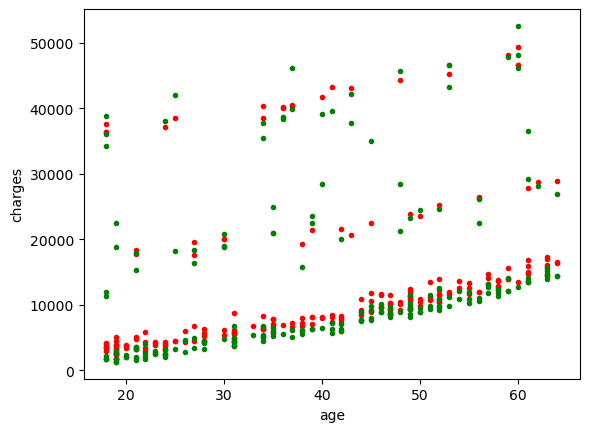

In [24]:
import matplotlib.pyplot as plt

#Charges = f ( age )
plt.xlabel("age")
plt.ylabel("charges")
plt.plot(X_test["age"], y_predicted, "r.")
plt.plot(X_test["age"], y_test, "g.")
plt.show()

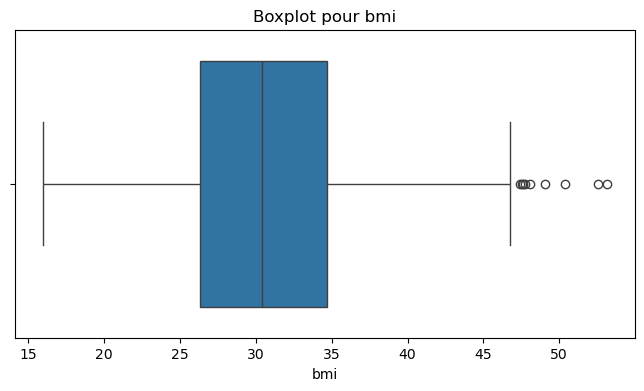

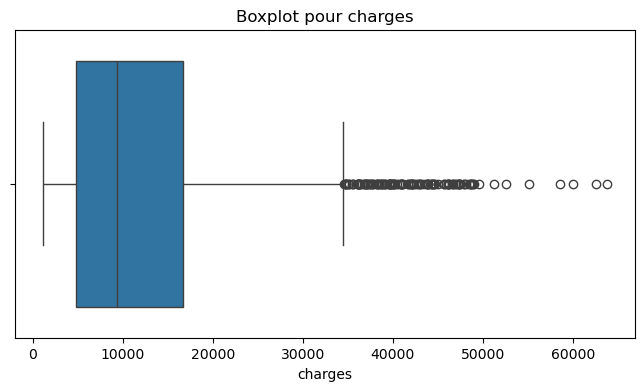

In [ ]:
columns_to_check = ['bmi', 'charges']

for col in columns_to_check:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=dataframe[col])
    plt.title(f"Boxplot pour {col}")
    plt.show()

In [92]:
# Fonction pour repérer les valeurs aberrantes basées sur l'IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Repérer les valeurs aberrantes dans `bmi` et `charges`
outliers_bmi = detect_outliers_iqr(dataframe, 'bmi')
outliers_charges = detect_outliers_iqr(dataframe, 'charges')

print("Valeurs aberrantes dans bmi :")
print(outliers_bmi)

print("\nValeurs aberrantes dans charges :")
print(outliers_charges)


Valeurs aberrantes dans bmi :
      age     sex    bmi  children smoker     region      charges
116    58    male  49.06         0     no  southeast  11381.32540
286    46  female  48.07         2     no  northeast   9432.92530
401    47    male  47.52         1     no  southeast   8083.91980
543    54  female  47.41         0    yes  southeast  63770.42801
847    23    male  50.38         1     no  southeast   2438.05520
860    37  female  47.60         2    yes  southwest  46113.51100
1047   22    male  52.58         1    yes  southeast  44501.39820
1088   52    male  47.74         1     no  southeast   9748.91060
1317   18    male  53.13         0     no  southeast   1163.46270

Valeurs aberrantes dans charges :
      age     sex     bmi  children smoker     region      charges
14     27    male  42.130         0    yes  southeast  39611.75770
19     30    male  35.300         0    yes  southwest  36837.46700
23     34  female  31.920         1    yes  northeast  37701.87680
29     

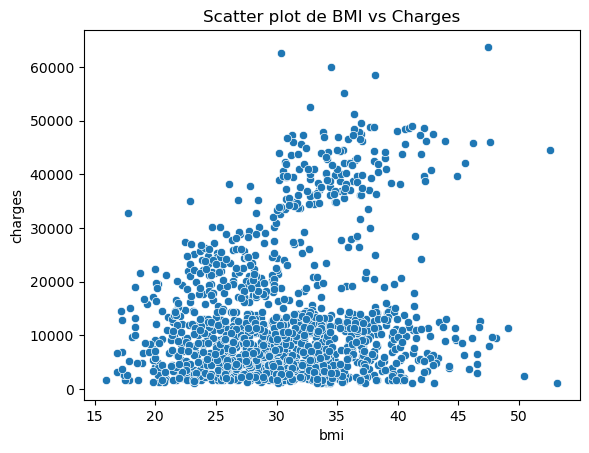

In [93]:
sns.scatterplot(data=dataframe, x='bmi', y='charges')
plt.title("Scatter plot de BMI vs Charges")
plt.show()


In [94]:
dataframe_cleaned = dataframe [dataframe['charges']<=60000]